In [1]:
pip install catboost

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from datetime import timedelta

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor


In [6]:
data = pd.read_csv('municipality_bus_utilization.csv')

In [7]:
data['time'] = pd.to_datetime(data['timestamp'])

SOME INSTANCES HAVE USAGE > CAPACITY WHICH SHOULD BE CORRECTED BY CLIPPING USAGE BY CAPACITY ON THOSE INSTANCES

In [8]:
data[data['usage']>data['total_capacity']]

,timestamp,municipality_id,usage,total_capacity,time
7618,2017-07-17 12:04:02,1,399,397,2017-07-17 12:04:02
7621,2017-07-17 12:31:03,1,401,397,2017-07-17 12:31:03
7635,2017-07-17 13:04:03,1,399,397,2017-07-17 13:04:03
7648,2017-07-17 13:31:03,1,403,397,2017-07-17 13:31:03
7659,2017-07-17 14:04:03,1,403,397,2017-07-17 14:04:03
...,...,...,...,...,...
13010,2017-08-19 14:03:31,1,408,397,2017-08-19 14:03:31
13026,2017-08-19 14:30:33,1,410,397,2017-08-19 14:30:33
13037,2017-08-19 15:03:34,1,408,397,2017-08-19 15:03:34
13048,2017-08-19 15:29:33,1,411,397,2017-08-19 15:29:33


In [9]:
data.loc[data[data['usage']>data['total_capacity']].index,'usage'] = data.loc[data[data['usage']>data['total_capacity']].index,'total_capacity']

In [10]:
def fn(time,min,sec):
  a = time - timedelta(minutes=min, seconds=sec)
  return a

In [11]:
data.head(1)

,timestamp,municipality_id,usage,total_capacity,time
0,2017-06-04 07:59:42,9,454,1332,2017-06-04 07:59:42


In [12]:
data['day'] = data['time'].dt.day
data['month'] = data['time'].dt.month
data['hour'] = data['time'].dt.hour
data['minute'] = data['time'].dt.minute
data['second'] = data['time'].dt.second

In [13]:
data['time'] = data[['time','minute','second']].apply(lambda x: fn(*x), axis=1)

In [14]:
data_new = pd.DataFrame(data.groupby(['time','municipality_id'])['usage','total_capacity'].max()).reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [15]:
data_new

,time,municipality_id,usage,total_capacity
0,2017-06-04 07:00:00,0,204,2813
1,2017-06-04 07:00:00,1,129,397
2,2017-06-04 07:00:00,2,273,697
3,2017-06-04 07:00:00,3,623,1930
4,2017-06-04 07:00:00,4,1090,3893
...,...,...,...,...
6735,2017-08-19 16:00:00,5,239,587
6736,2017-08-19 16:00:00,6,1727,3113
6737,2017-08-19 16:00:00,7,1450,2019
6738,2017-08-19 16:00:00,8,1253,2947


In [16]:
data = data_new

In [17]:
data['day'] = data['time'].dt.day
data['month'] = data['time'].dt.month
data['hour'] = data['time'].dt.hour

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff87e065450>,
      dtype=object)

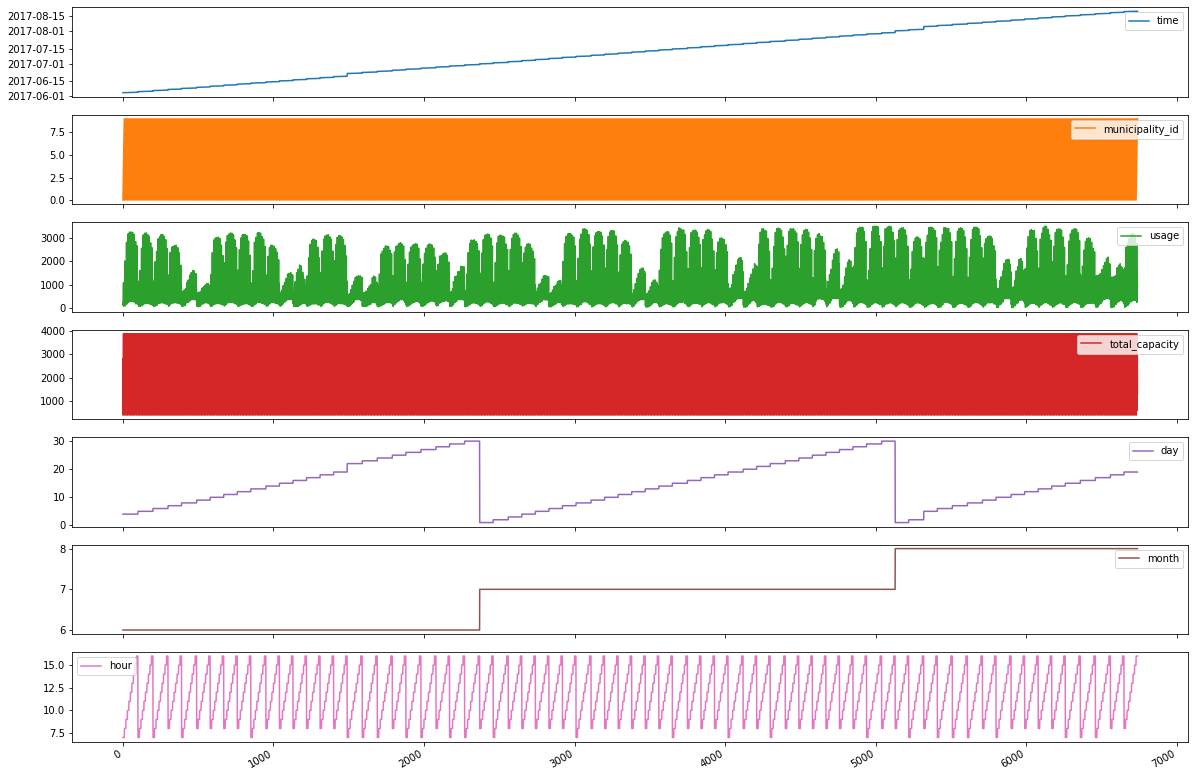

In [18]:
data.plot(subplots=True, figsize=(20,15))

SPIKES IN TIME GRAPH INDICATE MISSING VALUES

In [19]:
data['time'].dt.hour.value_counts()

15    720
11    720
14    720
10    720
13    720
9     720
16    720
12    720
8     720
7     260
Name: time, dtype: int64

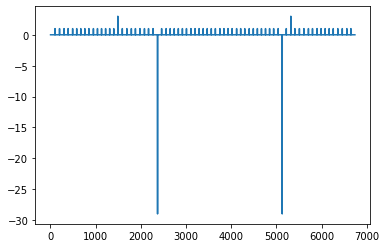

In [20]:
plt.plot(data['day'].diff())

In [21]:
data['day'].diff().value_counts()
#there are two occuracnces of 2 day long missing values in the data

 0.0     6668
 1.0       67
-29.0       2
 3.0        2
Name: day, dtype: int64

In [22]:
data[data['day'].diff()>1]['day']
#locating the jumps

1490    22
5320     5
Name: day, dtype: int64

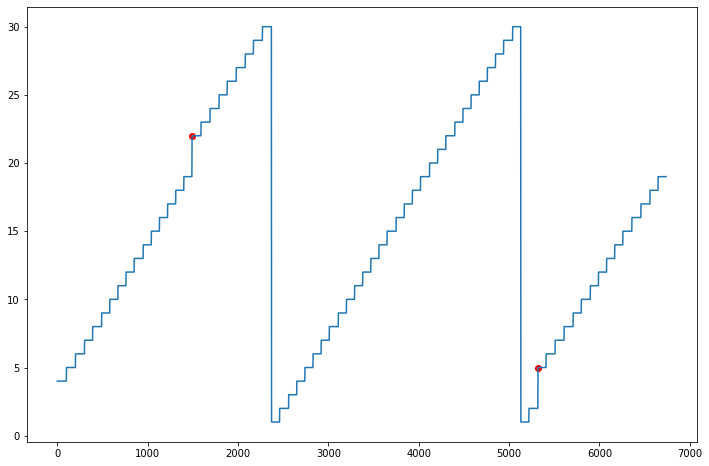

In [23]:
#visualizing
plt.figure(figsize=(12,8))
plt.plot(data['day'])
plt.scatter(1490,data.loc[1490,'day'], color='red')
plt.scatter(5320,data.loc[5320,'day'], color='red')

In [24]:
#missing values:
#2017-06-20 #2017-06-21
#2017-08-03 #2017-08-04 
#and 460 days have a missing 07:00:00 timestamp 
#-> we need to impute

FILLING THE MISSING INSTANCES WITH NANS

In [25]:
mun0 = data[data['municipality_id']==0]
mun1 = data[data['municipality_id']==1]
mun2 = data[data['municipality_id']==2]
mun3 = data[data['municipality_id']==3]
mun4 = data[data['municipality_id']==4]
mun5 = data[data['municipality_id']==5]
mun6 = data[data['municipality_id']==6]
mun7 = data[data['municipality_id']==7]
mun8 = data[data['municipality_id']==8]
mun9 = data[data['municipality_id']==9]


In [26]:
len(mun0),len(mun1),len(mun2),len(mun3),len(mun4),len(mun5),len(mun6),len(mun7),len(mun8),len(mun9)

(674, 674, 674, 674, 674, 674, 674, 674, 674, 674)

In [27]:
#every municipality df have the missing values at identical places

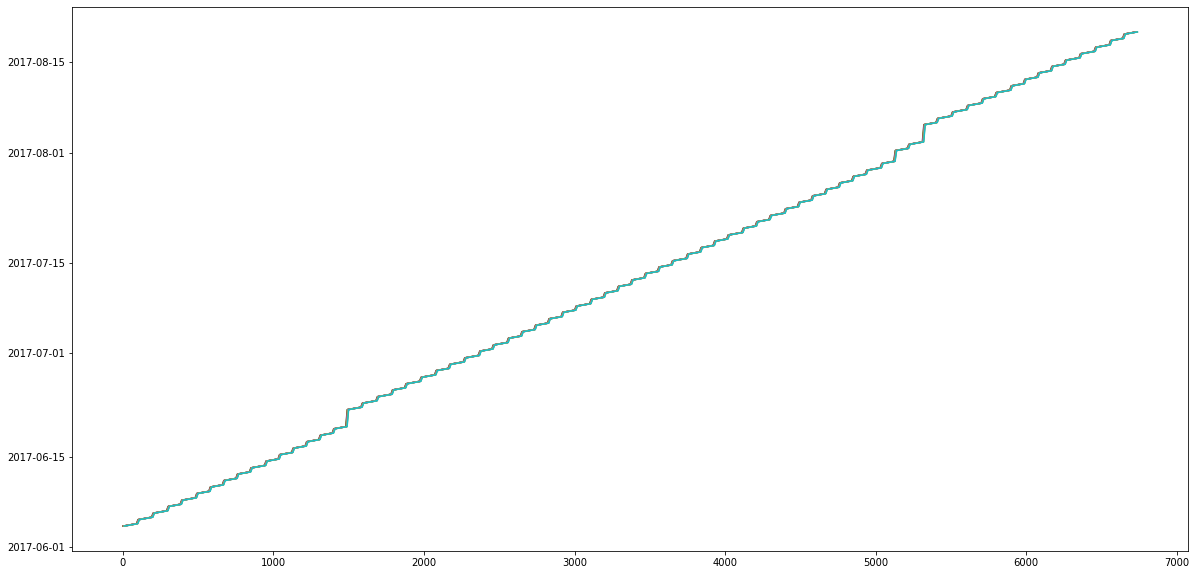

In [28]:
plt.figure(figsize=(20,10))
plt.plot(mun0['time'])
plt.plot(mun1['time'])
plt.plot(mun2['time'])
plt.plot(mun3['time'])
plt.plot(mun4['time'])
plt.plot(mun5['time'])
plt.plot(mun6['time'])
plt.plot(mun7['time'])
plt.plot(mun8['time'])
plt.plot(mun9['time'])

In [29]:
r = pd.date_range(start=mun0.time.min(), end=mun0.time.max(), freq='H')
mun0_tc = mun0.set_index('time').reindex(r).fillna('NaN').rename_axis('time').reset_index()
mun1_tc = mun1.set_index('time').reindex(r).fillna('NaN').rename_axis('time').reset_index()
mun2_tc = mun2.set_index('time').reindex(r).fillna('NaN').rename_axis('time').reset_index()
mun3_tc = mun3.set_index('time').reindex(r).fillna('NaN').rename_axis('time').reset_index()
mun4_tc = mun4.set_index('time').reindex(r).fillna('NaN').rename_axis('time').reset_index()
mun5_tc = mun5.set_index('time').reindex(r).fillna('NaN').rename_axis('time').reset_index()
mun6_tc = mun6.set_index('time').reindex(r).fillna('NaN').rename_axis('time').reset_index()
mun7_tc = mun7.set_index('time').reindex(r).fillna('NaN').rename_axis('time').reset_index()
mun8_tc = mun8.set_index('time').reindex(r).fillna('NaN').rename_axis('time').reset_index()
mun9_tc = mun9.set_index('time').reindex(r).fillna('NaN').rename_axis('time').reset_index()

In [30]:
mun0_tc['hour'] = mun0_tc['time'].dt.hour
mun0_tc['day'] = mun0_tc['time'].dt.day
mun0_tc['month'] = mun0_tc['time'].dt.month

In [31]:
mun1_tc['hour'] = mun1_tc['time'].dt.hour
mun1_tc['day'] = mun1_tc['time'].dt.day
mun1_tc['month'] = mun1_tc['time'].dt.month

In [32]:
mun2_tc['hour'] = mun2_tc['time'].dt.hour
mun2_tc['day'] = mun2_tc['time'].dt.day
mun2_tc['month'] = mun2_tc['time'].dt.month

In [33]:
mun3_tc['hour'] = mun3_tc['time'].dt.hour
mun3_tc['day'] = mun3_tc['time'].dt.day
mun3_tc['month'] = mun3_tc['time'].dt.month

In [34]:
mun4_tc['hour'] = mun4_tc['time'].dt.hour
mun4_tc['day'] = mun4_tc['time'].dt.day
mun4_tc['month'] = mun4_tc['time'].dt.month

In [35]:
mun5_tc['hour'] = mun5_tc['time'].dt.hour
mun5_tc['day'] = mun5_tc['time'].dt.day
mun5_tc['month'] = mun5_tc['time'].dt.month

In [36]:
mun6_tc['hour'] = mun6_tc['time'].dt.hour
mun6_tc['day'] = mun6_tc['time'].dt.day
mun6_tc['month'] = mun6_tc['time'].dt.month

In [37]:
mun7_tc['hour'] = mun7_tc['time'].dt.hour
mun7_tc['day'] = mun7_tc['time'].dt.day
mun7_tc['month'] = mun7_tc['time'].dt.month

In [38]:
mun8_tc['hour'] = mun8_tc['time'].dt.hour
mun8_tc['day'] = mun8_tc['time'].dt.day
mun8_tc['month'] = mun8_tc['time'].dt.month

In [39]:
mun9_tc['hour'] = mun9_tc['time'].dt.hour
mun9_tc['day'] = mun9_tc['time'].dt.day
mun9_tc['month'] = mun9_tc['time'].dt.month

In [40]:
mun_dic = {0:mun0_tc,1:mun1_tc,2:mun2_tc,3:mun3_tc,4:mun4_tc,5:mun5_tc,6:mun6_tc,7:mun7_tc,8:mun8_tc,9:mun9_tc}

In [41]:
for key, value in mun_dic.items():
  value['municipality_id']=key
  print(sum(mun_dic[key]['municipality_id']!=key))

0
0
0
0
0
0
0
0
0
0


In [42]:
new_dic={}
for key, value in mun_dic.items():
  new_dic['newmun'+str(key)] = value[(value['hour']>6) & (value['hour']<17)]

In [43]:
df = pd.concat(new_dic.values(), ignore_index=True)

In [44]:
df_nans = df[df['usage']=='NaN']

In [45]:
df_nans[['usage','total_capacity']] = np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [46]:
df_copy = df

In [47]:
df_copy.loc[df_copy['usage']=='NaN','usage'] = np.nan
df_copy.loc[df_copy['total_capacity']=='NaN','total_capacity'] = np.nan

In [48]:
df_copy.dtypes

time               datetime64[ns]
municipality_id             int64
usage                      object
total_capacity             object
day                         int64
month                       int64
hour                        int64
dtype: object

In [49]:
df_copy.isnull().sum()

time                 0
municipality_id      0
usage              960
total_capacity     960
day                  0
month                0
hour                 0
dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff866e77b50>,
      dtype=object)

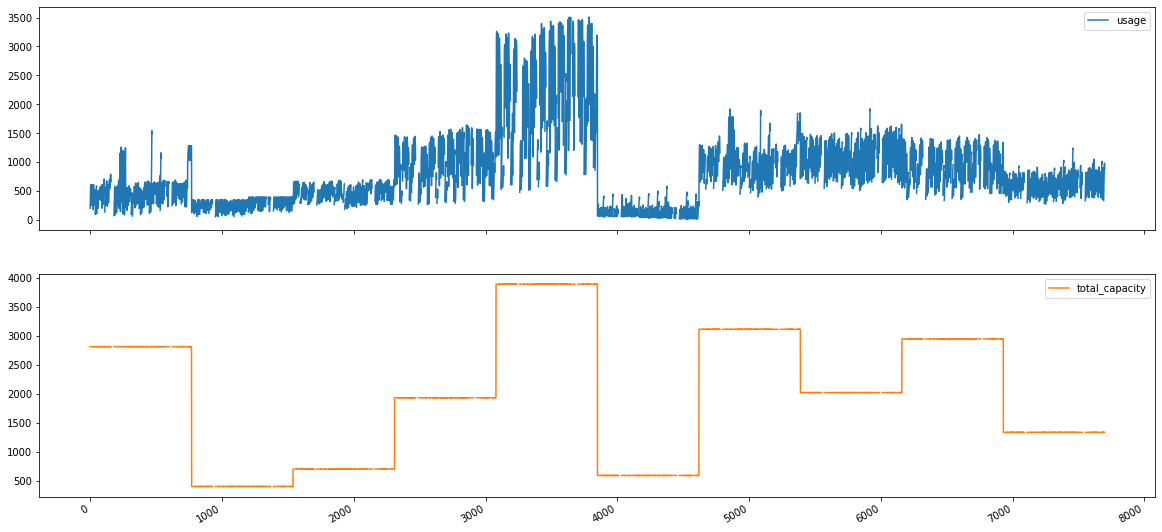

In [50]:
df_copy[['usage','total_capacity']].plot(subplots=True,figsize=(20,10))

In [51]:
df_copy.head(1)

,time,municipality_id,usage,total_capacity,day,month,hour
0,2017-06-04 07:00:00,0,204,2813,4,6,7




> IMPUTING


IMPUTING TOTAL CAPACITY BY BACKFILL TO PRESERVE CAPACITY CORRESPONDING TO MUNICIPALITY ID

In [52]:
df_imp = df_copy

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff864e58690>,
      dtype=object)

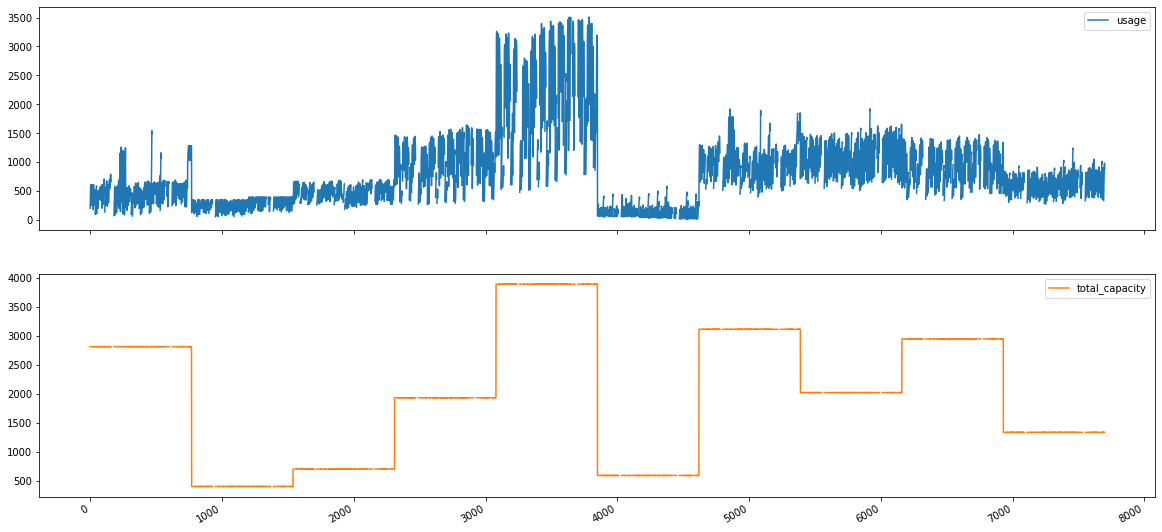

In [53]:
df_imp[['usage','total_capacity']].plot(subplots=True,figsize=(20,10))

In [54]:
df_imp['total_capacity'] = df_imp['total_capacity'].fillna(method='bfill')

In [55]:
df_imp.isnull().sum()

time                 0
municipality_id      0
usage              960
total_capacity       0
day                  0
month                0
hour                 0
dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff864d7e210>,
      dtype=object)

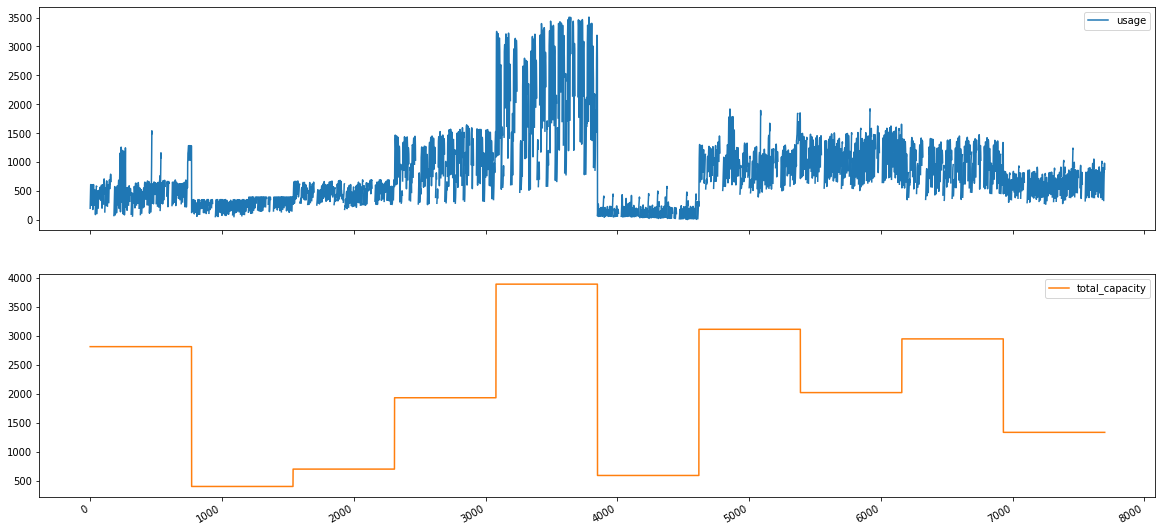

In [56]:
df_imp[['usage','total_capacity']].plot(subplots=True,figsize=(20,10))

IMPUTING USAGE BY KNN, ITERATIVE IMP AND SIMPLE IMP

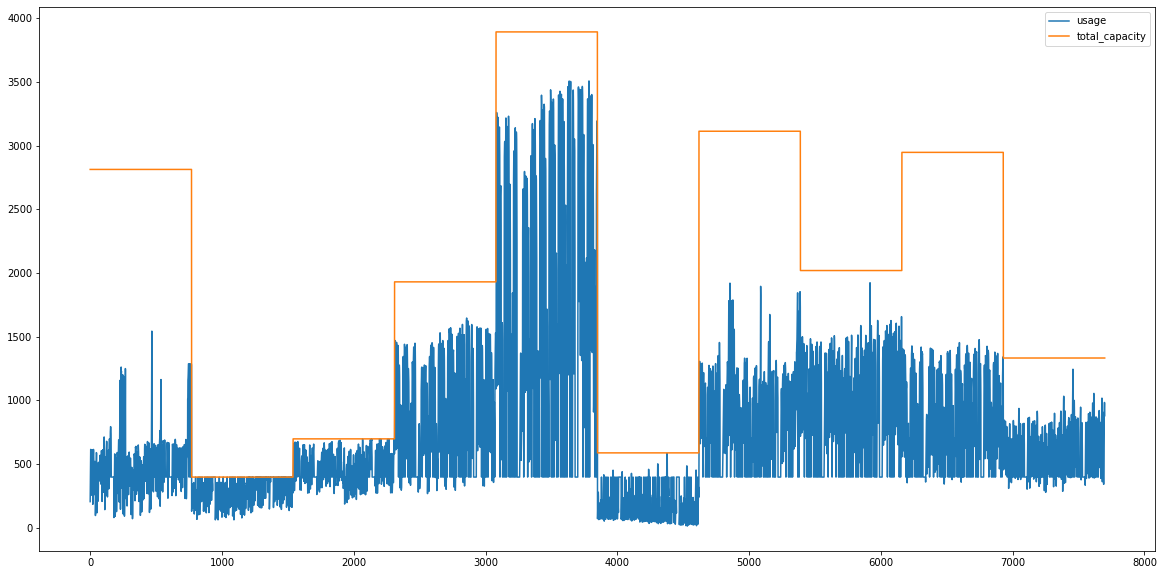

In [57]:
simp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_imp_simp = pd.DataFrame(simp.fit_transform(df_imp.set_index('time')), columns=df_imp.columns[1:])
df_imp_simp[['usage','total_capacity']].plot(subplots=False,figsize=(20,10))

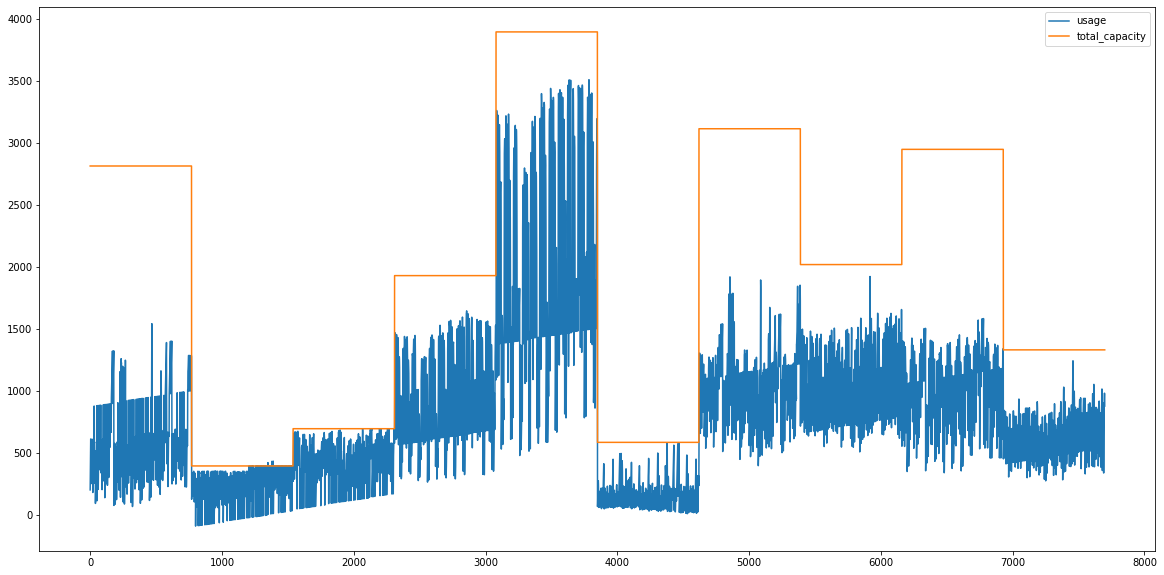

In [58]:
imp = IterativeImputer(max_iter=10, random_state=0)
df_imp_ii = pd.DataFrame(imp.fit_transform(df_imp.set_index('time')), columns=df_imp.columns[1:])
df_imp_ii[['usage','total_capacity']].plot(subplots=False,figsize=(20,10))

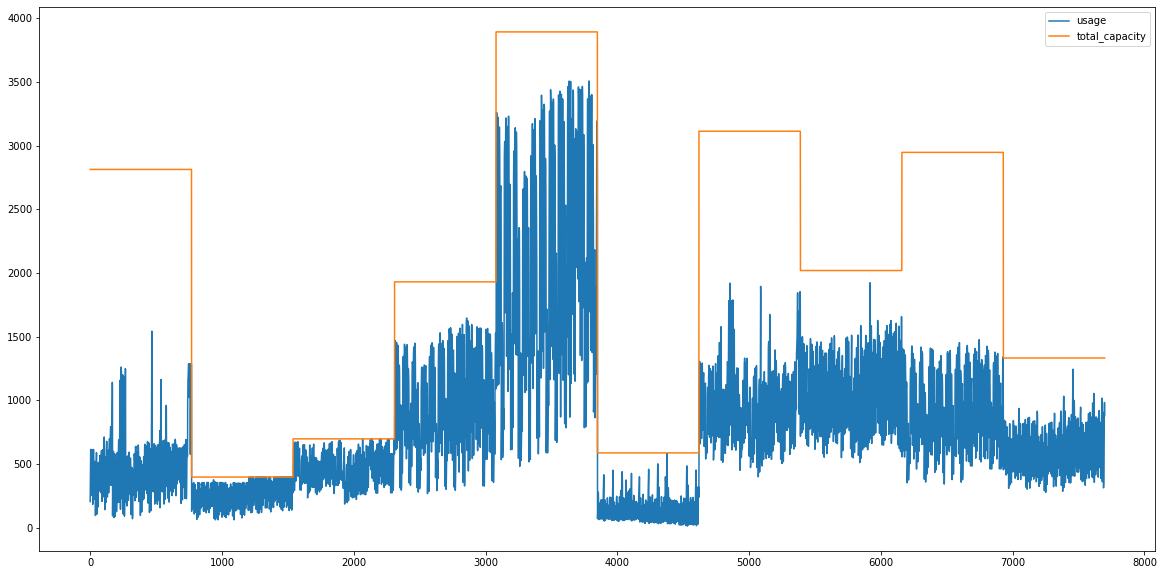

In [59]:
imputer = KNNImputer(n_neighbors=2)
df_imp_knn = pd.DataFrame(imputer.fit_transform(df_imp.set_index('time')), columns=df_imp.columns[1:])
df_imp_knn[['usage','total_capacity']].plot(subplots=False,figsize=(20,10))

CHOOSING KNN SINCE IT OBEYS THE CAPACITY AND IS MORE ROBUST OVERALL (LATER ON I ALSO CHECKED FOR NAIVE BASELINE PREDICTION KNN GIVES BEST RMSE)

In [60]:
data = df_imp_knn

In [61]:
for col in data.columns:
  data[col] = data[col].astype('int')
data.dtypes

municipality_id    int64
usage              int64
total_capacity     int64
day                int64
month              int64
hour               int64
dtype: object

In [62]:
data.head(1)

,municipality_id,usage,total_capacity,day,month,hour
0,0,204,2813,4,6,7


WE WILL NEED THE NON-DROPNA APPLIED TEST INDEXES FOR THE BASELINE PREDICTION

In [63]:
test_4_index = data[(data['month'].isin([8])) & (data['day'].isin([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]))]

ADDING LAG FEATURES

In [64]:
data_lag = data.shift(150)
data_lag.columns = data.columns + '150lag'

In [65]:
#lags of 15 days to prevent data leak on test set
df_lag = pd.DataFrame(pd.concat([data,data_lag],axis=1))

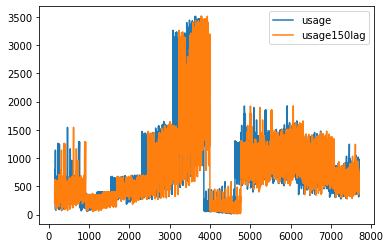

In [66]:
df_lag[['usage','usage150lag']].dropna().plot()

In [67]:
df_lag['tobenan'] = df_lag.iloc[:,0] - df_lag.iloc[:,6]
df_lag.drop(['municipality_id150lag','total_capacity150lag','day150lag','month150lag','hour150lag'],axis=1, inplace=True)

In [68]:
df_lag['tobenan2'] = df_lag['tobenan'].apply(lambda x:0 if x==0 else np.nan)

In [69]:
df_lag['usage150lagnan'] = df_lag[['usage150lag','tobenan2']].apply(lambda x:x['usage150lag'] if x['tobenan2'] == 0 else np.nan, axis=1)
df_lag.drop(['tobenan','tobenan2','usage150lag'],axis=1,inplace=True)

In [70]:
df_lag['usage150lagnan'].isnull().sum()

1500

In [71]:
df_lag.shape

(7700, 7)

In [72]:
df_lag_dropna = df_lag.dropna().reset_index(drop=True)

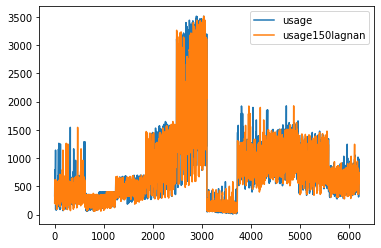

In [73]:
df_lag_dropna[['usage','usage150lagnan']].plot()

In [74]:
df_lag_dropna.head(1)

,municipality_id,usage,total_capacity,day,month,hour,usage150lagnan
0,0,333,2813,19,6,7,204.0


In [75]:
data = df_lag_dropna

In [76]:
data.shape

(6200, 7)

SPLITTING THE DATA

In [77]:
train = data[~((data['month'].isin([8])) & (data['day'].isin([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])))]

In [78]:
test = data[(data['month'].isin([8])) & (data['day'].isin([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]))]

In [79]:
X_train, y_train = train.drop('usage',1), train['usage']
X_test, y_test = test.drop('usage',1), test['usage']

In [80]:
X_train_dum = pd.concat([pd.DataFrame(X_train).reset_index(drop=True),pd.get_dummies(X_train['municipality_id'], prefix='m').reset_index(drop=True)],axis=1)
X_train_dum = X_train_dum.rename(columns={0:'municipality_id',1:'total_capacity', 2:'day', 3:'month', 4:'hour', 5:'minute', 6:'second'}).drop('municipality_id',1)

In [81]:
X_test_dum = pd.concat([pd.DataFrame(X_test).reset_index(drop=True),pd.get_dummies(X_test['municipality_id'], prefix='m').reset_index(drop=True)],axis=1)
X_test_dum = X_test_dum.rename(columns={0:'municipality_id',1:'total_capacity', 2:'day', 3:'month', 4:'hour', 5:'minute', 6:'second'}).drop('municipality_id',1)

TRIG FEATURES

In [82]:
def add_sct(df,cols):
    d = {}
    for col in cols:
        d[col+'sin'] = np.sin(df[col])*2*np.pi/(df[col].nunique())
        d[col+'cos'] = np.cos(df[col])*2*np.pi/(df[col].nunique())
        d[col+'tan'] = np.tan(df[col])*2*np.pi/(df[col].nunique())

    concat_data = pd.concat([df, pd.DataFrame(d)], axis=1)
    return concat_data.drop(cols,1)

In [83]:
X_train_trig = add_sct(X_train_dum,['day','month'])
X_test_trig = add_sct(X_test_dum,['day','month'])

In [84]:
X_train_trig.head(2)

,total_capacity,hour,usage150lagnan,m_0,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,daysin,daycos,daytan,monthsin,monthcos,monthtan
0,2813,7,204.0,1,0,0,0,0,0,0,0,0,0,0.030378,0.200394,0.030725,-0.585206,2.010976,-0.609482
1,2813,8,332.0,1,0,0,0,0,0,0,0,0,0,0.030378,0.200394,0.030725,-0.585206,2.010976,-0.609482


In [85]:
cortrain = pd.concat([X_train_trig.reset_index(drop=True),y_train.reset_index(drop=True)],1)
cortest = pd.concat([X_test_trig.reset_index(drop=True),y_test.reset_index(drop=True)],1)
cordata = pd.concat([cortrain.reset_index(drop=True),cortest.reset_index(drop=True)],axis=0)
cordata

,total_capacity,hour,usage150lagnan,m_0,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,daysin,daycos,daytan,monthsin,monthcos,monthtan,usage
0,2813,7,204.0,1,0,0,0,0,0,0,0,0,0,0.030378,0.200394,0.030725,-0.585206,2.010976,-0.609482,333
1,2813,8,332.0,1,0,0,0,0,0,0,0,0,0,0.030378,0.200394,0.030725,-0.585206,2.010976,-0.609482,548
2,2813,9,485.0,1,0,0,0,0,0,0,0,0,0,0.030378,0.200394,0.030725,-0.585206,2.010976,-0.609482,665
3,2813,10,583.0,1,0,0,0,0,0,0,0,0,0,0.030378,0.200394,0.030725,-0.585206,2.010976,-0.609482,751
4,2813,11,614.0,1,0,0,0,0,0,0,0,0,0,0.030378,0.200394,0.030725,-0.585206,2.010976,-0.609482,766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1332,12,718.0,0,0,0,0,0,0,0,0,0,1,0.062780,0.414148,0.063498,6.216321,-0.914204,-42.723847,849
1496,1332,13,745.0,0,0,0,0,0,0,0,0,0,1,0.062780,0.414148,0.063498,6.216321,-0.914204,-42.723847,941
1497,1332,14,719.0,0,0,0,0,0,0,0,0,0,1,0.062780,0.414148,0.063498,6.216321,-0.914204,-42.723847,983
1498,1332,15,645.0,0,0,0,0,0,0,0,0,0,1,0.062780,0.414148,0.063498,6.216321,-0.914204,-42.723847,976


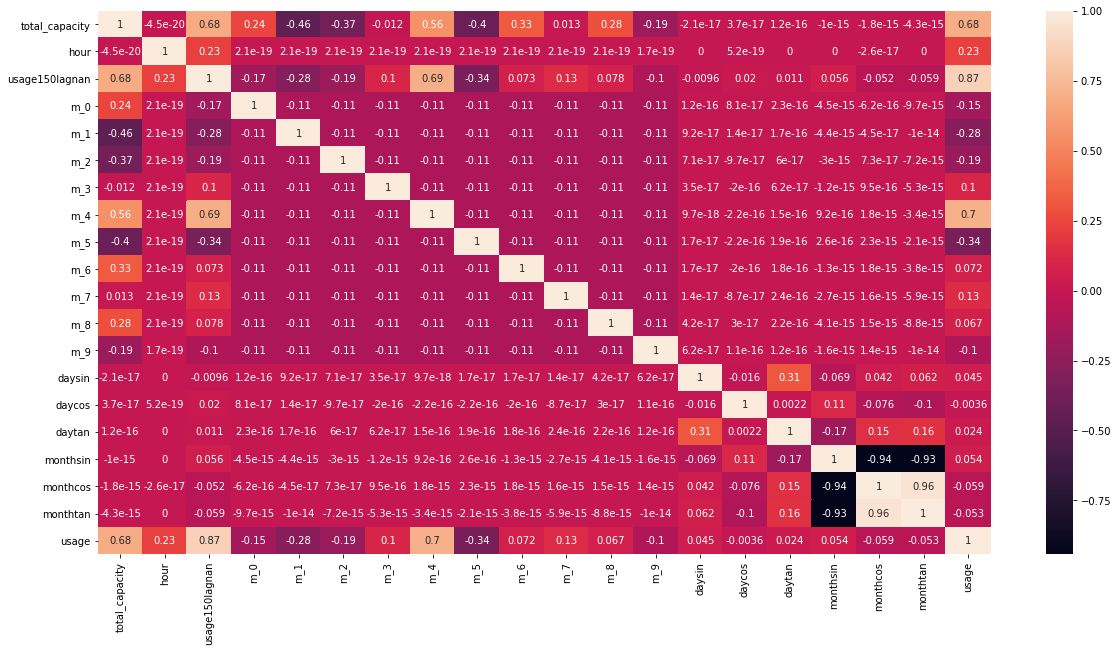

In [86]:
corr = cordata.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True)

<Figure size 1080x576 with 0 Axes>

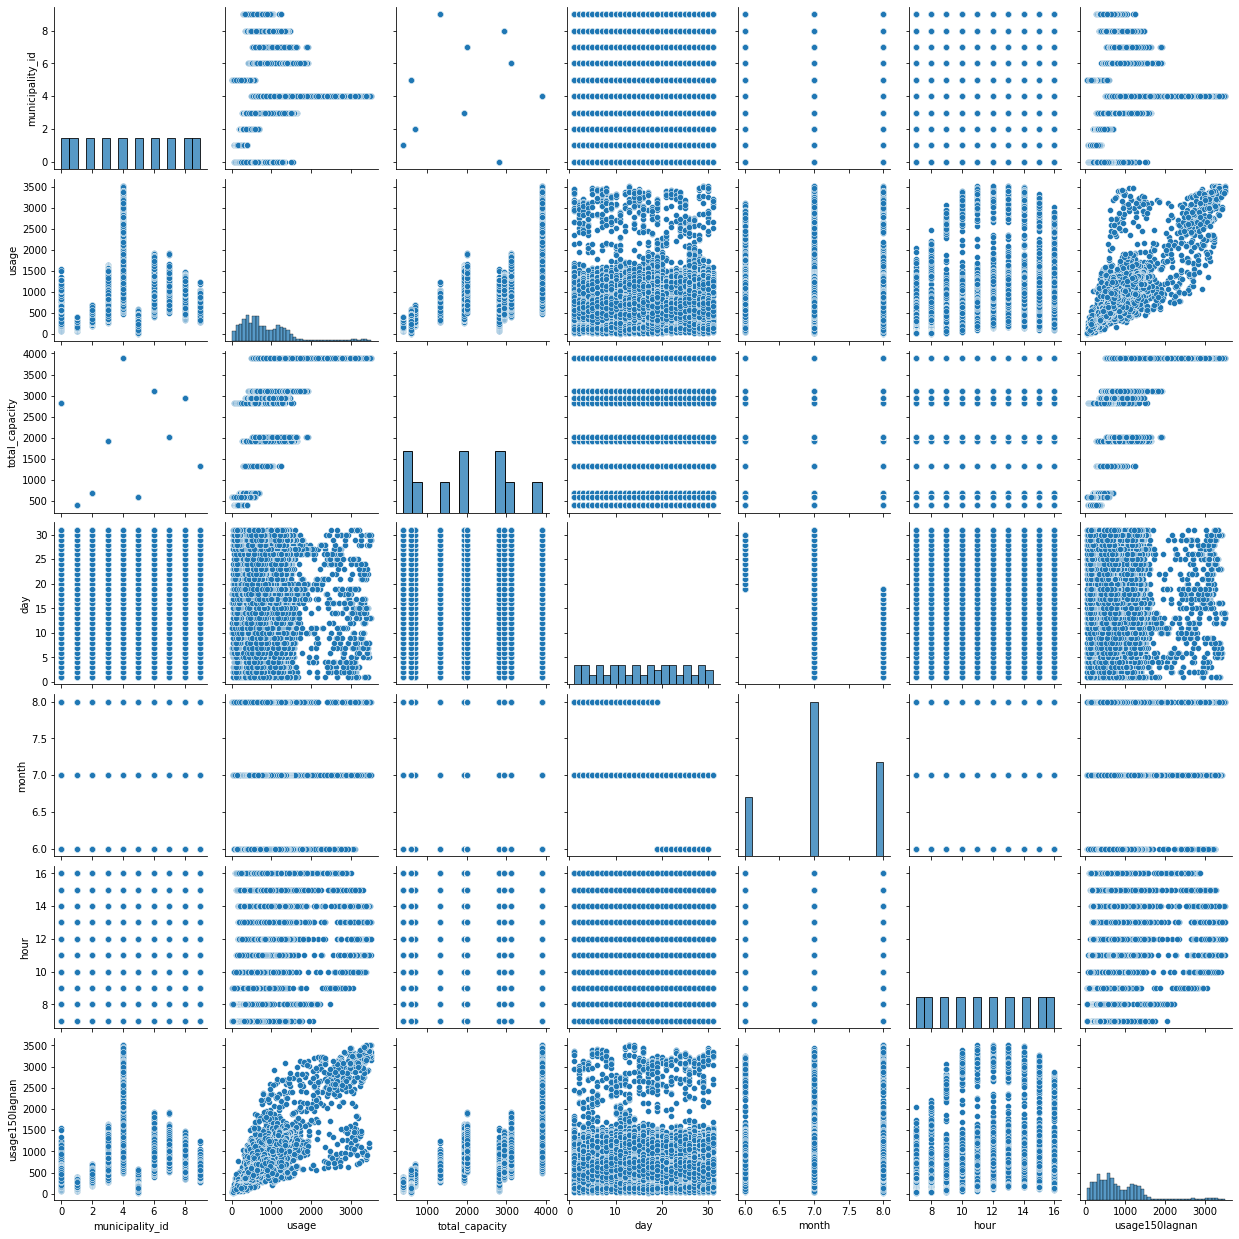

In [87]:
plt.figure(figsize=(15,8))
sns.pairplot(data)

In [88]:
#dropping cols with low correlation with target

In [89]:
X_train_trig.drop(['m_6','m_7','m_8','m_9','daysin','daycos','daytan','monthsin','monthcos','monthtan'],1,inplace=True)
X_test_trig.drop(['m_6','m_7','m_8','m_9','daysin','daycos','daytan','monthsin','monthcos','monthtan'],1,inplace=True)

SCALING BEFORE FITTING

In [90]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train_trig)
X_test_sc = sc.transform(X_test_trig)

In [91]:
print(X_train_sc.shape,y_train.shape,X_test_sc.shape,y_test.shape)

(4700, 9) (4700,) (1500, 9) (1500,)


In [92]:
data_for_last = data.copy()

## MODELING

## BASELINE MODEL

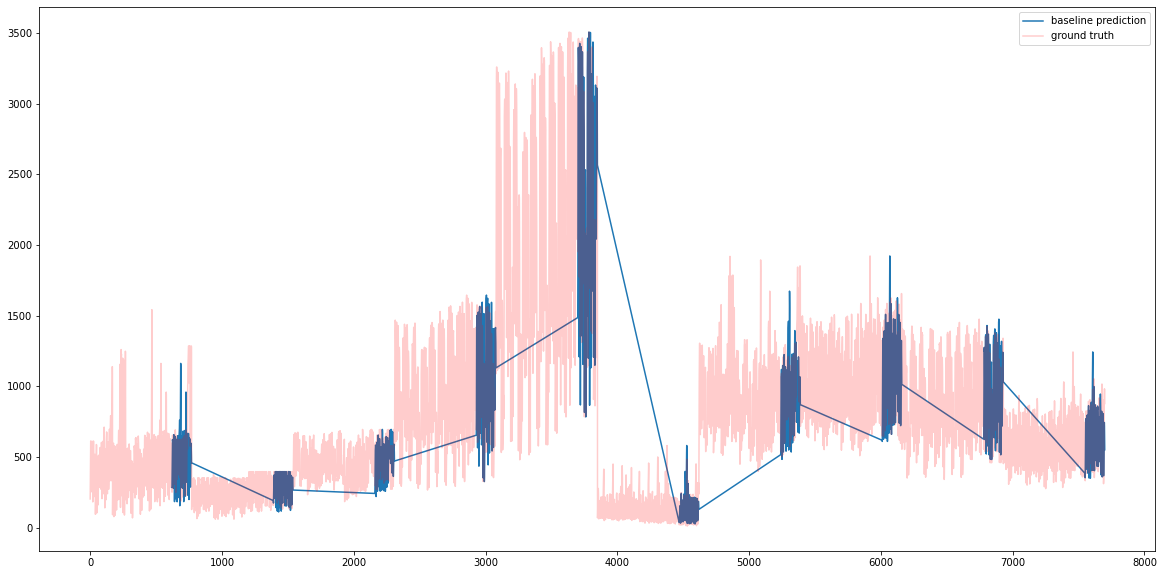

In [93]:
#we will be using values with 15 days lag 
baseline_pred = df_imp_knn.shift(150)
#seperated by the municipalities
plt.figure(figsize=(20,10))
plt.plot(baseline_pred.loc[test_4_index.index,'usage'],label='baseline prediction')
plt.plot(df_imp_knn['usage'], color='red', alpha=0.2,label='ground truth')
plt.legend()
#plt.plot(y_test,color='purple')

In [94]:
print('baseline_pred_rmse',np.sqrt(mean_squared_error(y_test,baseline_pred.loc[test_4_index.index,'usage'])))

baseline_pred_rmse 238.52887595984404


# COMPLEX MODELING
We need to make sure the values are bounded by (min=0 and max=total capacity) and is integer

In [95]:
#NOW WE SHOULD TRY TO GET BETTER RMSE THAN 238

In [96]:
lr = LinearRegression()
sgd = SGDRegressor()
h = HuberRegressor(max_iter=1000)
ran = RANSACRegressor()
svr = svm.SVR()
rf = RandomForestRegressor()
dt = DecisionTreeRegressor()
xg = XGBRegressor(verbosity=0)
las = Lasso()
rid = Ridge()
gb = GradientBoostingRegressor(random_state=1, verbose=0)
mlpr = MLPRegressor(hidden_layer_sizes=[40,40,40], learning_rate='adaptive', early_stopping=True, max_iter=1000, random_state=42)
cat = CatBoostRegressor(loss_function='RMSE', verbose=0)
bag = BaggingRegressor(base_estimator=lr)
knr = KNeighborsRegressor(n_neighbors=3)

FITTING UNPROCESSED DATA

In [97]:
d = {} #lr,ran
for model in [gb,cat,h,mlpr]:
  model.fit(X_train,y_train)
  pred = model.predict(X_test)
  pred = np.round(pred,0)
  pred = np.clip(pred,0,np.inf)
  pred = np.minimum(pred,X_test['total_capacity'])
  d[str(model).split('Reg')[0]+'prediction'] = pred
  d = pd.DataFrame(d)
  print(model,np.sqrt(mean_squared_error(y_test,pred)))

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 260.3117822919278
<catboost.core.CatBoostRegressor object at 0x7ff858695510> 327.5515369118779
HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=1000,
               tol=1e-05, warm_start=False) 225.225128852592
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999,

FITTING PROCESSED DATA

In [98]:
d = {} #lr,ran
for model in [gb,cat,h,mlpr]:
  model.fit(X_train_sc,y_train)
  pred = model.predict(X_test_sc)
  pred = np.round(pred,0)
  pred = np.clip(pred,0,np.inf)
  pred = np.minimum(pred,sc.inverse_transform(X_test_sc)[:,0])
  d[str(model).split('Reg')[0]+'prediction'] = pred
  d = pd.DataFrame(d)
  print(model,np.sqrt(mean_squared_error(y_test,pred)))

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 238.71998100982947
<catboost.core.CatBoostRegressor object at 0x7ff858695510> 239.34866617551893
HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=1000,
               tol=1e-05, warm_start=False) 238.68622080044756
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.

In [99]:
#It should be noted that huber outperformed all others in the UNPROCESSED DATA indicating processed data hides outliers in the data. 
#Huber classifies outliers better on the UNPROCESSED DATA

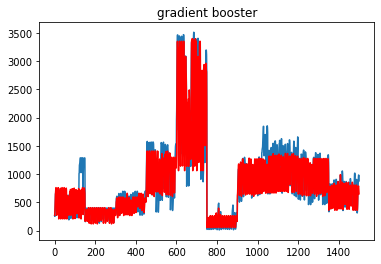

In [100]:
#GB and HUBER egalated baseline without any hyperparameter search so it has potential
#lets see how GB is doing
plt.title('gradient booster')
plt.plot(y_test.reset_index(drop=True))
plt.plot(gb.predict(X_test_sc), color='red')
plt.show()

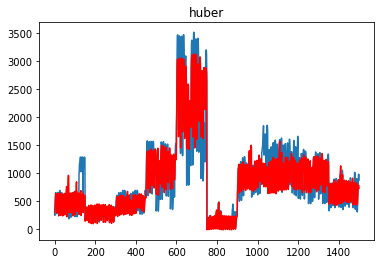

In [101]:
plt.title('huber')
plt.plot(y_test.reset_index(drop=True))
plt.plot(h.predict(X_test_sc), color='red')
plt.show()

LETS TRY SOME PARAMETERS ON HUBER REGRESSOR

In [102]:
for i in np.linspace(1.3,2,20):
  print(i)
  hub = HuberRegressor(epsilon = i, max_iter=1000)
  hub.fit(X_train,y_train)
  h_pred = hub.predict(X_test)
  print(np.sqrt(mean_squared_error(y_test,h_pred)))
  #a simple manual search yields optimum epsilon = 1.63 we will use this value, other parameters are searched similarly, no improvement seen.

1.3
225.25833653532328
1.3368421052631578
225.2469317231671
1.3736842105263158
229.1850157127194
1.4105263157894736
225.23495783328175
1.4473684210526316
225.22230729303547
1.4842105263157894
225.19312104848908
1.5210526315789474
225.17373030186425
1.5578947368421052
225.1622115916312
1.5947368421052632
225.1591165733588
1.631578947368421
225.15556040883146
1.668421052631579
225.1589036282315
1.7052631578947368
225.18004437673977
1.7421052631578946
225.21289455739463
1.7789473684210526
225.2632828369292
1.8157894736842106
225.34291014974215
1.8526315789473684
225.39697656888313
1.8894736842105262
225.47815183908202
1.9263157894736842
225.56839131203165
1.9631578947368422
225.6631029507586
2.0
225.75985107721056


SAVING BEST HUBER PREDICTION AND MODEL

In [103]:
h_best = HuberRegressor(epsilon=1.63)
h_best.fit(X_train,y_train)
h_best_pred = h_best.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,h_best_pred)))

225.15285630993318


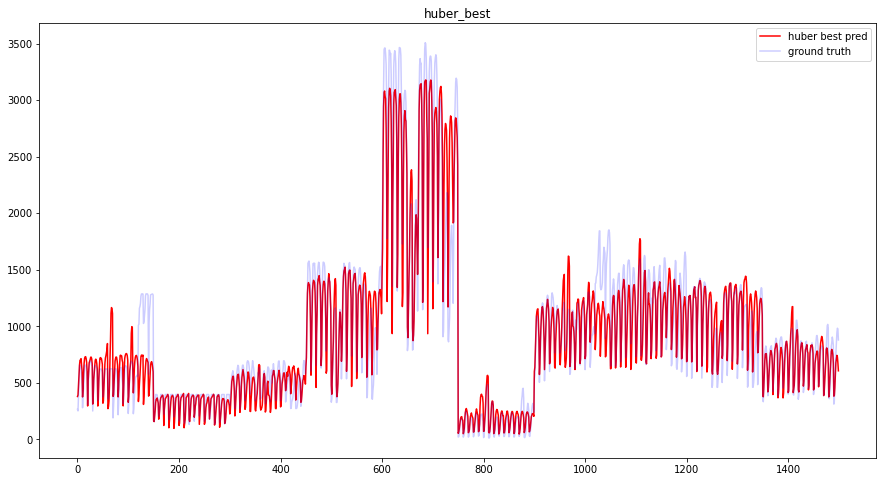

In [104]:
plt.figure(figsize=(15,8))
plt.title('huber_best')
plt.plot(h_best_pred, label='huber best pred', color = 'red')
plt.plot(y_test.reset_index(drop=True), label='ground truth', color = 'blue', alpha=0.2)
plt.legend()

PARAM SEARCH FOR GB

In [105]:
for loss in ['ls','lad','huber']:
  print(loss)
  gradboost = GradientBoostingRegressor(loss = loss)
  gradboost.fit(X_train_sc,y_train)
  gb_pred = gradboost.predict(X_test_sc)
  print(np.sqrt(mean_squared_error(y_test,gb_pred)))
  #lad is the best loss fxn

ls
238.7116612905598
lad
239.01182017663885
huber
246.31652790620672


In [106]:
for learning_rate in np.linspace(0.057,0.06,20):
  print(learning_rate)
  gradboost = GradientBoostingRegressor(loss = 'lad', learning_rate = learning_rate)
  gradboost.fit(X_train_sc,y_train)
  gb_pred = gradboost.predict(X_test_sc)
  print(np.sqrt(mean_squared_error(y_test,gb_pred)))
  #0.0592 is the best learning rate

0.057
232.52145773191285
0.05715789473684211
233.5499135132967
0.05731578947368421
231.08811550484018
0.057473684210526316
231.72508163359052
0.05763157894736842
230.60071527367265
0.05778947368421053
234.21771535825778
0.05794736842105263
236.03146552881338
0.058105263157894736
234.4411120195422
0.05826315789473684
232.9893667887076
0.05842105263157895
234.36360958243745
0.05857894736842105
234.90543404175168
0.05873684210526316
233.88393572994212
0.058894736842105264
232.9384047401449
0.05905263157894737
232.26527540598244
0.05921052631578947
231.09567727447666
0.05936842105263158
234.2392614318764
0.059526315789473684
235.33311206851718
0.05968421052631579
234.42605207637044
0.05984210526315789
234.6335094769519
0.06
232.4734433429573


In [107]:
for n_estimators in list(range(85,95)):
  print(n_estimators)
  gradboost = GradientBoostingRegressor(loss = 'lad',learning_rate=0.0592,n_estimators = n_estimators)
  gradboost.fit(X_train_sc,y_train)
  gb_pred = gradboost.predict(X_test_sc)
  print(np.sqrt(mean_squared_error(y_test,gb_pred)))
  #n_estimators = 93

85
230.76031867630462
86
230.4813260087932
87
230.30310274813476
88
230.3081134173683
89
230.16971745442095
90
230.121252119628
91
229.84590423313884
92
229.76273224167298
93
230.06267313409117
94
230.41204989001696


In [108]:
#I want to keep param optimization section short since it is more of brute forcing rather than something thoughtful

230.06499075977268


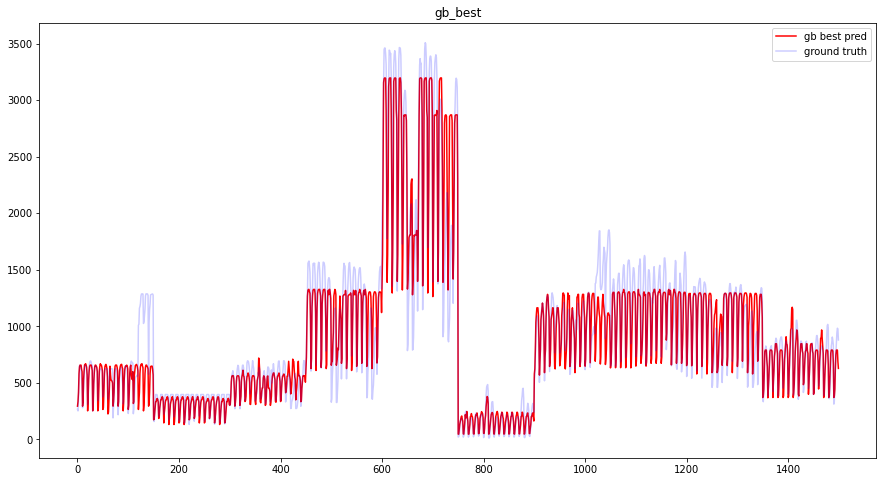

In [109]:
best_gb = GradientBoostingRegressor(n_estimators=93, loss = 'lad',learning_rate=0.0592)
best_gb.fit(X_train_sc,y_train)
best_gb_pred = best_gb.predict(X_test_sc)
print(np.sqrt(mean_squared_error(y_test,best_gb_pred)))
plt.figure(figsize=(15,8))
plt.title('gb_best')
plt.plot(best_gb_pred, label='gb best pred', color = 'red')
plt.plot(y_test.reset_index(drop=True), label='ground truth', color = 'blue', alpha=0.2)
plt.legend()

## TARGET TRANSFORMATION

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


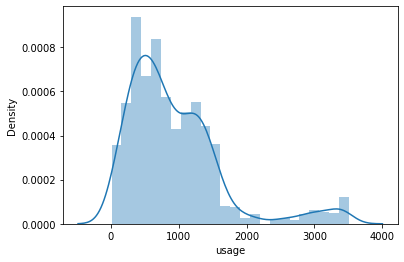

In [110]:
sns.distplot(y_test)

Our target is skewed, and ML models prefer gaussian distributions so we should try transforming by the state of the art method box-cox

In [111]:
y_box,fitted_lambda= boxcox(y_train,lmbda=None)
y_inv = inv_boxcox(y_box,fitted_lambda)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


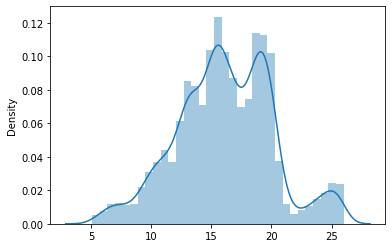

In [112]:
sns.distplot(y_box)

In [113]:
mlpr = MLPRegressor(hidden_layer_sizes=[32,32,32], learning_rate='adaptive', early_stopping=True, random_state=7, max_iter=1000)
#best_fitting
d = {} #lr,ran
for model in [best_gb,cat,h_best,mlpr]:
  model.fit(X_train_sc,y_train)
  pred = model.predict(X_test_sc)
  pred = np.round(pred,0)
  pred = np.clip(pred,0,np.inf)
  pred = np.minimum(pred,sc.inverse_transform(X_test_sc)[:,0])
  d[str(model).split('Reg')[0]+'prediction'] = pred
  d = pd.DataFrame(d)
  print(model,np.sqrt(mean_squared_error(y_test,pred)))

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.0592, loss='lad',
                          max_depth=3, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=93,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 230.08035697700635
<catboost.core.CatBoostRegressor object at 0x7ff858695510> 239.34866617551893
HuberRegressor(alpha=0.0001, epsilon=1.63, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False) 240.84566150683858
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta

WITH TRANSFORMED TARGET

In [114]:
l = {}
for model in [best_gb,cat,h_best,mlpr]:
  model.fit(X_train_sc,y_box)
  pred = model.predict(X_test_sc)
  pred = np.round(pred,0)
  pred = np.clip(pred,0,np.inf)
  pred = np.minimum(pred,sc.inverse_transform(X_test_sc)[:,0])
  l[str(model).split('Reg')[0]+'prediction'] = pred
  l = pd.DataFrame(l)
  print(model,np.sqrt(mean_squared_error(y_test,inv_boxcox(pred,fitted_lambda))))

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.0592, loss='lad',
                          max_depth=3, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=93,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 242.6984634503523
<catboost.core.CatBoostRegressor object at 0x7ff858695510> 239.5842066536396
HuberRegressor(alpha=0.0001, epsilon=1.63, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False) 264.030235116604
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0

TRANSFORMED TARGET WAS EXPECTED TO IMPROVE RESULTS BUT IT DIDN'T, MOVING ON TO ENSEMBLING

## ENSEMBLE

In [115]:
mlpr = MLPRegressor(hidden_layer_sizes=[40,40,40], learning_rate='adaptive', early_stopping=True, random_state=666, max_iter=1000)
cat = CatBoostRegressor(learning_rate=0.007,verbose=0)
knr = KNeighborsRegressor(n_neighbors=10)
#best_fitting
d = {} #lr,ran
for model in [best_gb,cat,h_best,mlpr,knr]:
  model.fit(X_train_sc,y_train)
  pred = model.predict(X_test_sc)
  pred = np.round(pred,0)
  pred = np.clip(pred,0,np.inf)
  pred = np.minimum(pred,sc.inverse_transform(X_test_sc)[:,0])
  d[str(model).split('Reg')[0]+'prediction'] = pred
  d = pd.DataFrame(d)
  print(model,np.sqrt(mean_squared_error(y_test,pred)))

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.0592, loss='lad',
                          max_depth=3, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=93,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 230.07702623252067
<catboost.core.CatBoostRegressor object at 0x7ff8573ce2d0> 235.21918572542788
HuberRegressor(alpha=0.0001, epsilon=1.63, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False) 240.84566150683858
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta

In [116]:
#we will take the arithmetic mean
d['mean'] = d.mean(axis=1)
mean = d['mean']
mean = np.round(mean,0)
mean = np.clip(mean,0,np.inf)
mean = np.minimum(mean,sc.inverse_transform(X_test_sc)[:,0])
d['mean'] = mean
d['ground truth'] = y_test.reset_index(drop=True)
d

,GradientBoostingprediction,<catboost.core.CatBoostprediction,Huberprediction,MLPprediction,KNeighborsprediction,mean,ground truth
0,294.0,248.0,292.0,234.0,201.0,254.0,266
1,333.0,282.0,319.0,306.0,274.0,303.0,252
2,416.0,418.0,401.0,399.0,360.0,399.0,393
3,582.0,552.0,468.0,498.0,534.0,527.0,517
4,643.0,647.0,551.0,591.0,704.0,627.0,653
...,...,...,...,...,...,...,...
1495,790.0,774.0,760.0,802.0,808.0,787.0,849
1496,790.0,794.0,798.0,845.0,850.0,815.0,941
1497,790.0,790.0,807.0,816.0,808.0,802.0,983
1498,689.0,738.0,789.0,755.0,785.0,751.0,976


In [117]:
#weighted mean with weights from linear regressing top models with the target is our best result
#4 models
w_mean = d['GradientBoostingprediction']*0.37 + d['<catboost.core.CatBoostprediction']*0.07 + d['Huberprediction']*0.20 + d['MLPprediction'] *0.37
np.sqrt(mean_squared_error(d['ground truth'],w_mean))

224.29652954678843

In [118]:
#5 models
wk_mean = d['GradientBoostingprediction']*0.27 + d['<catboost.core.CatBoostprediction']*0.068 + d['Huberprediction']*0.2 +d['MLPprediction'] *0.38 + d['KNeighborsprediction']*0.10
np.sqrt(mean_squared_error(d['ground truth'],wk_mean))

224.19902240658115

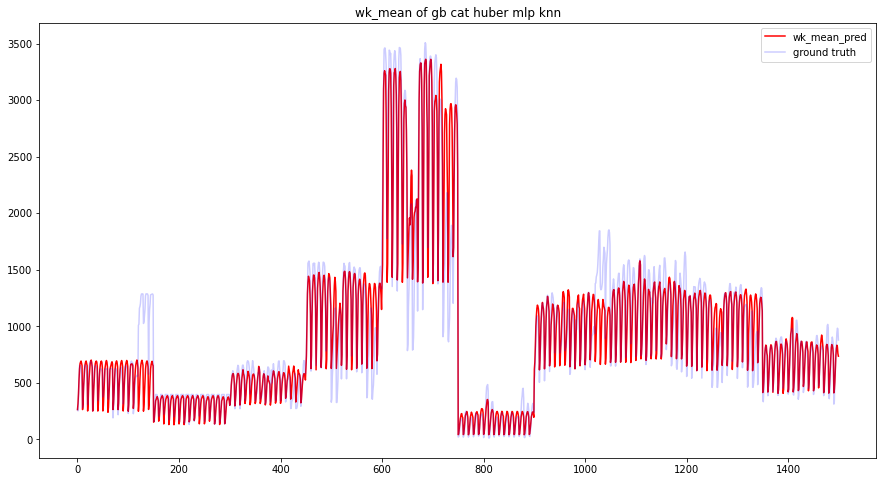

In [119]:
plt.figure(figsize=(15,8))
plt.title('wk_mean of gb cat huber mlp knn')
plt.plot(wk_mean, label='wk_mean_pred', color = 'red')
plt.plot(y_test.reset_index(drop=True), label='ground truth', color = 'blue', alpha=0.2)
plt.legend()

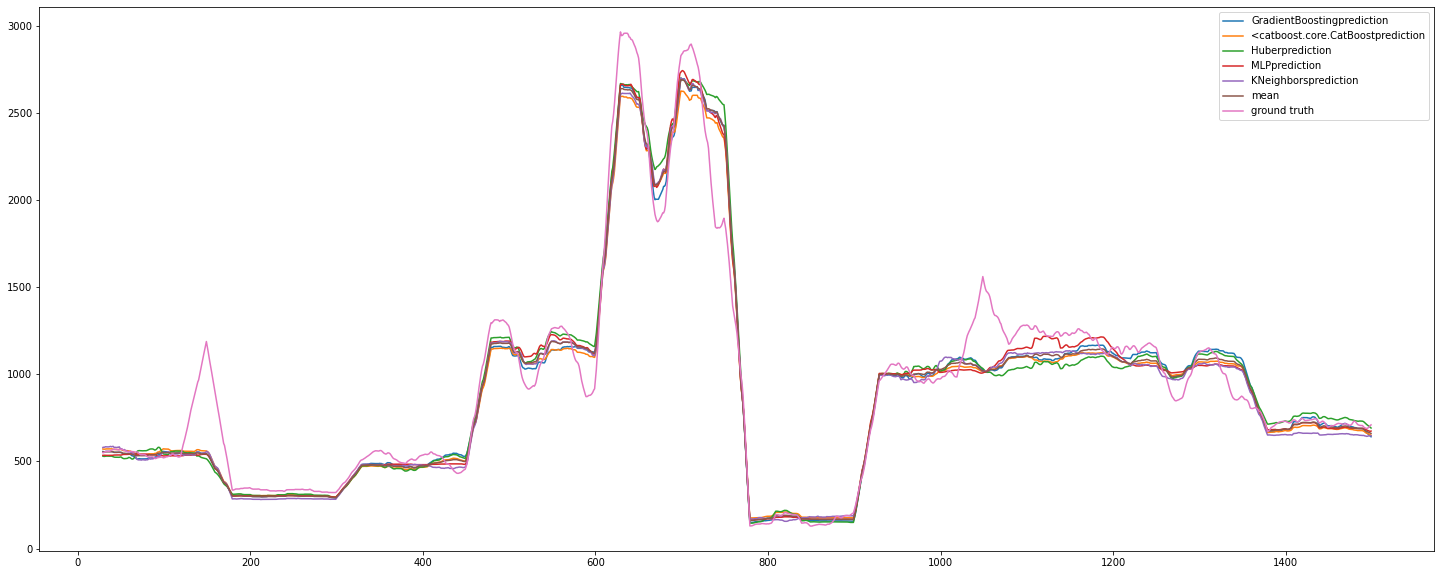

In [120]:
d.rolling(window=30).mean().plot(figsize=(25,10))

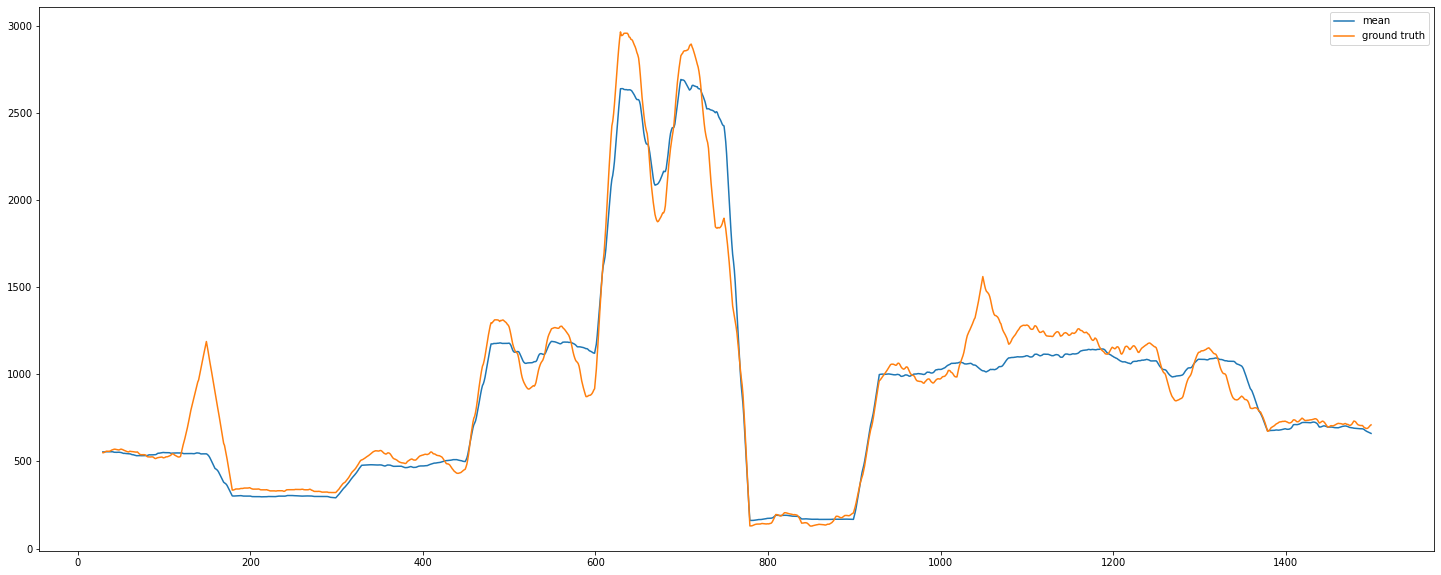

In [121]:
d[['mean','ground truth']].rolling(window=30).mean().plot(figsize=(25,10))

In [122]:
#taking a simple mean of the best performing models (GB,MLP,CATBOOST,HUBER,KNN) did better than all of them.

WE CAN DEVELOP THIS WITH VOTING, BAGGING, BOOSTING REGRESSORS

In [123]:
def fit_predict(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    test_pred = model.predict(X_test)
    df = pd.DataFrame(test_pred, columns=['pred'])
    df['cap'] = X_test['total_capacity'].reset_index(drop=True)
    test_pred_new = df.min(axis=1)
    test_pred_new_zero = np.clip(df.min(axis=1),0,np.inf)
    print(str(model).split('(')[0],'test_rmse_bound_zero',np.sqrt(mean_squared_error(y_test,test_pred_new_zero)))
    return test_pred_new_zero

In [124]:
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_trig.columns)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test_trig.columns)

TRYING SKLEARN ENSEMBLE REGRESSORS

In [126]:
vr = VotingRegressor([('mlpr',mlpr),('h_best',h_best),('cat',cat),('best_gb',best_gb)])
bag = BaggingRegressor(bootstrap_features=False, base_estimator=cat)

In [127]:
#voting regressor did not improve the basic weighted mean combination enough
vr_pred = vr.fit(X_train_sc,y_train).predict(X_test_sc)
vr_pred = np.round(vr_pred,0)
vr_pred = np.clip(vr_pred,0,np.inf)
vr_pred = np.minimum(vr_pred,sc.inverse_transform(X_test_sc)[:,0])
np.sqrt(mean_squared_error(y_test,vr_pred))

225.80291111202854

In [128]:
bag_pred = bag.fit(X_train_sc,y_train).predict(X_test_sc)
bag_pred = np.round(bag_pred,0)
bag_pred = np.clip(bag_pred,0,np.inf)
bag_pred = np.minimum(bag_pred,sc.inverse_transform(X_test_sc)[:,0])
np.sqrt(mean_squared_error(y_test,bag_pred))

236.10217562177044

# TIME SERIES ANALYSIS
First observations on the target looked very stationary which complies with our adf test
The tenth day has a significant autocorrelation which can not be used for a two week prediction but can be used for 1 week prediction.

In [129]:
data = pd.read_csv('municipality_bus_utilization.csv')

data['time'] = pd.to_datetime(data['timestamp'])

"""SOME INSTANCES HAVE USAGE > CAPACITY WHICH SHOULD BE CORRECTED"""

data[data['usage']>data['total_capacity']]

data.loc[data[data['usage']>data['total_capacity']].index,'usage'] = data.loc[data[data['usage']>data['total_capacity']].index,'total_capacity']

def fn(time,min,sec):
  a = time - timedelta(minutes=min, seconds=sec)
  return a

data.head(1)

data['day'] = data['time'].dt.day
data['month'] = data['time'].dt.month
data['hour'] = data['time'].dt.hour
data['minute'] = data['time'].dt.minute
data['second'] = data['time'].dt.second

data['time'] = data[['time','minute','second']].apply(lambda x: fn(*x), axis=1)

data_new = pd.DataFrame(data.groupby(['time','municipality_id'])['usage','total_capacity'].max()).reset_index()

data_new

data = data_new

data['day'] = data['time'].dt.day
data['month'] = data['time'].dt.month
data['hour'] = data['time'].dt.hour

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [130]:
usage = data['usage']

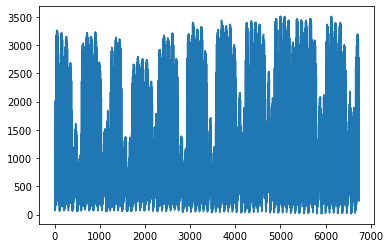

In [131]:
usage.plot()

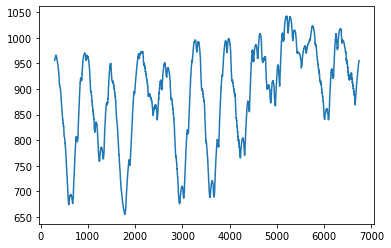

In [132]:
usage.rolling(window=300).mean().plot()

In [133]:
def adf_test(series, signif=0.05):
    dftest = adfuller(series, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags', '# Observations'])
    #for key, value in dftest[4].items():
    #    adf['Critical Value (%s)' % key] = value

    p = adf['p-value']
    if p <= signif:
        print(f"ADF TEST: Series is Stationary")
    else:
        print(f"ADF TEST: Series is Non-Stationary")

In [134]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [135]:
adf_test(usage)

ADF TEST: Series is Stationary


In [136]:
def acfs(X):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0] = plot_acf(X, ax=ax[0] ,lags=15)
    ax[1] = plot_pacf(X, ax=ax[1], lags=15)
    plt.show()

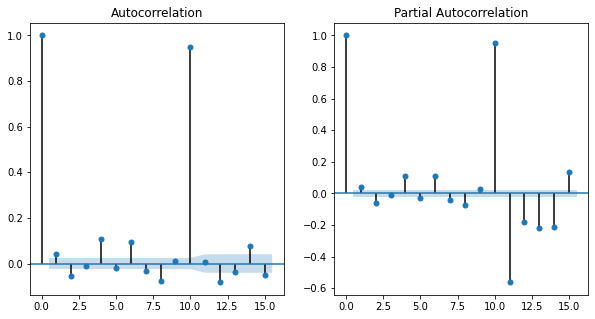

In [137]:
acfs(usage)

In [138]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

In [139]:
data

,time,municipality_id,usage,total_capacity,day,month,hour
0,2017-06-04 07:00:00,0,204,2813,4,6,7
1,2017-06-04 07:00:00,1,129,397,4,6,7
2,2017-06-04 07:00:00,2,273,697,4,6,7
3,2017-06-04 07:00:00,3,623,1930,4,6,7
4,2017-06-04 07:00:00,4,1090,3893,4,6,7
...,...,...,...,...,...,...,...
6735,2017-08-19 16:00:00,5,239,587,19,8,16
6736,2017-08-19 16:00:00,6,1727,3113,19,8,16
6737,2017-08-19 16:00:00,7,1450,2019,19,8,16
6738,2017-08-19 16:00:00,8,1253,2947,19,8,16


In [140]:
model = ARIMA(train.iloc[:770,1].reset_index(drop=True).values, order=(10,1,0))
results = model.fit(disp=-1)

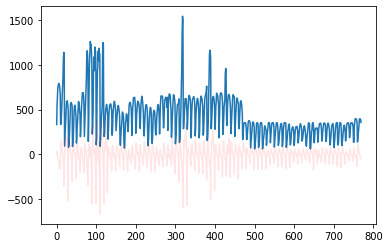

In [141]:
plt.plot(train.iloc[:770,1].reset_index(drop=True))
plt.plot(results.fittedvalues, color='red',alpha=0.1)

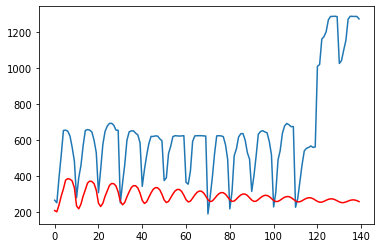

In [142]:
plt.plot(test.iloc[:140,1].reset_index(drop=True))
plt.plot(results.forecast(140)[0], color='red',alpha=1)

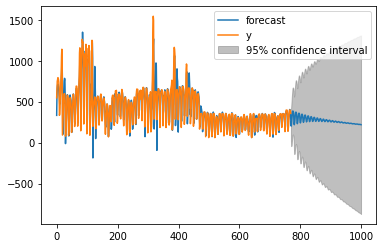

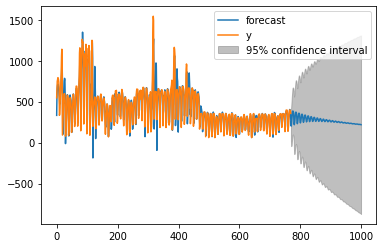

In [143]:
results.plot_predict(1,1000)

In [144]:
print('arima_rmse',np.sqrt(mean_squared_error(test.iloc[:140,1],results.forecast(140)[0])))

arima_rmse 434.6850261894485


In our case when we divide the data for each municipalities, there is not much left for sequential prediction, therefore I decided not to use the arima results, univariate nature of the model loses much of the significant information present in the data. Plus, arima gets worse and worse through the window.


# SUMMARY
# 1st place = Weighted arithmetic mean of parameter optimized gb,huber + mlpr + catboost + kneighbor on scaled data with lag feature RMSE = 224.2. Offering best result.
# 2nd place = HuberRegressor on non-preprocessed data RMSE = 225. Offering robust result and little work needed. Single model + no processing.
# 3rd place = Baseline prediction using the target values of last 2 weeks RMSE = 238. Offering no machine learning needed.

SUCCESS OF WEIGHTED MEAN: Taking the weighted mean of best performing models reduces overfitting which perceptrons and gradient boosters are known to be prone to. Averaging results from different type of models ie. Linear, tree, perceptron knn etc. allows to take advantage of each of their strong sides.

SUCCESS OF HUBER:
HuberRegressor is a variation of LinearRegression that is especially strong against outliers. It is dangerous to try to manually eliminate the outliers in this data as we dont have much data and outliers are heavily dispersed. Therefore I found huber to be more robust.

SUCCESS OF BASELINE: This approach is the by far least work and can be considered as a naive one, its success heavily relies on the fact that it gets values from an appropriate range and the continuity assumption of data.

# 1 Week Ahead Prediction 

CREATING A DATAFRAME FOR THE NEXT 1 WEEK AND PROCESSING IT THE SAME WAY AS BEFORE AND FITTING

In [145]:
#lag15days
data = data_for_last
usage150lagnan = data[(data['month'].isin([8])) & (data['day'].isin(list(range(5,12))))].reset_index(drop=True)['usage']
usage150lagnan

0       266
1       252
2       393
3       517
4       653
       ... 
695     924
696    1052
697    1054
698    1011
699     896
Name: usage, Length: 700, dtype: int64

In [146]:
data['hour'].value_counts()

15    620
11    620
7     620
14    620
10    620
13    620
9     620
16    620
12    620
8     620
Name: hour, dtype: int64

In [147]:
data_for_future_pred = data[(data['month'].isin([7])) & (data['day'].isin(list(range(20,27))))].reset_index(drop=True)
data_for_future_pred['month'] = data_for_future_pred['month'] + 1
data_for_future_pred 
dffp = data_for_future_pred

In [148]:
dffp_dum = pd.concat([pd.DataFrame(dffp).reset_index(drop=True),pd.get_dummies(dffp['municipality_id'], prefix='m').reset_index(drop=True)],axis=1)
dffp_dum.drop(['municipality_id','m_6','m_7','m_8','m_9','month','day','usage'],1,inplace=True)
dffp_dum['usage150lagnan'] = usage150lagnan
last_df = dffp_dum[['total_capacity', 'hour', 'usage150lagnan', 'm_0', 'm_1', 'm_2', 'm_3','m_4', 'm_5']].reset_index(drop=True)
sc.fit(X_train_trig.reset_index(drop=True))
last_df_sc = sc.transform(last_df)

In [149]:
#we will use voting regressor consisting of the best models for convenience
last_pred = vr.predict(last_df_sc)
last_pred = np.round(last_pred,0)
last_pred = np.clip(last_pred,0,np.inf)
last_pred = np.minimum(last_pred,sc.inverse_transform(last_df_sc)[:,0])

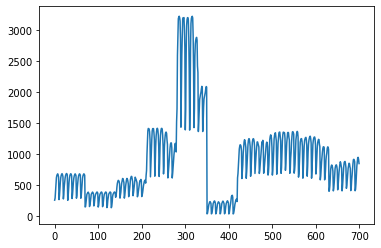

In [150]:
plt.plot(last_pred)

In [151]:
last_pred.shape

(700,)

In [152]:
pd.Series(last_pred).to_csv('PI_WORKS_1_w_ahead_pred.csv') 